## Introduction

You are working as an ML engineer in Visiemo, a famous sound-based sentiment analysis company. It’s Monday morning and you are chilling at the coffee machine with fellow Visiumees. Suddenly, the AI project manager schedules you a project kick-off meeting. A multinational client is interested in our services: the client has different call centers around the world and would like to analyze the satisfaction of its customers based on the recordings of the calls.

The client has heard about AI and Visiemo, more precisely about our expertise in sentiment analysis.
However,the client is reluctant in whether the solution will work. As such, it has been agreed to first do a proof-of-concept on the call centers from Germany.

At Visiemo, we have decided to use an already existing dataset and design a small proof-of-concept to showcase the solution to the client.

## Instructions

In the frame of this use-case, you will be confronted to **Speech Emotion Recognition** with the **Emo-DB** dataset. The goal is to design a proof-of-concept model which classifies samples of emotional speech in one of the given emotions.

By the end of the use-case, you should have a working model with good enough performance, fairly evaluated. 

*We do not aim to have the best performing model.* On the contrary, you should aim for an end-to-end working solution that enables inference on new speech samples.

* As a **report**, you should fill in the present notebook.
* You should dockerize your project. The **Docker container** should handle everything (download the data, run the code, etc.). When running the container **it should expose the Jupyter notebook on one port and expose a Flask API on another one**.
* The **Flask API** should contain two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* The code that you will develop should be **entirely reproducible** and **documented in a README.md file**.

## Final presentation

* The final presentation will be held on-site or remotely depending on your availability. 
* An AI Project Manager and two ML engineers will be present. 
* You will start by giving a 10-15 min technical presentation about your approach and your findings, using the slides provided as deliverables. Finally, a discussion with questions of about 20 min will follow.
* It should be clear enough to understand your approach and your decisions without going too much in the code. 
* You can also include code snippets, demos, etc.

## Important points to keep in mind

* Please be aware that this use-case might take a substantial amount of time, especially if you are not familiar with all the tools.
* You will have one full week to tackle the problem, starting today. We broadly estimate to *15-20 hours* the usual development time needed.
* Don’t spend too much time finding the perfect technical solution or making tiny metric improvements. 
* If you don't manage to finish all the tasks, you can still send us your use-case: we will discuss the difficulties you encountered during the final presentation.
* **Do not upload your code to Github, or at least not in a public repo.**
* Feel free to use any available library you would need, but **do not re-use someone else's code without mentioning it.**

## Deliverables 

Please provide the following elements in a **.zip** file as deliverables:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work.
* A **Dockerfile** defining a container for the project expositing the present notebook and the Flask API.
* A **README.md** which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* **Any** necessary .py, .sh or other files needed to run your code.

You will be judged on your technical approach, evaluation, visualizations, coding and presentation skills.

## About the data

The dataset can be found [here](http://emodb.bilderbar.info/index-1280.html).

It contains samples of emotional speech in German, labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information").

# Libraries Loading

In [1]:
from os import listdir, getcwd
from os.path import join, dirname
import pandas as pd
import librosa
import numpy as np
#from src import formatData
from src import plot_audio
from src import extractFeatures
from src import evaluation
from src import manageData

import torch
torch.manual_seed(2)


# 1. Data Preparation & Cleaning

## a) Data Loading

In [39]:
path_data = manageData.load_data()
PATH_DATA = join(path_data, 'wav')

data = manageData.createDataFrame(PATH_DATA)

import numpy as np

print(f'There are {data.shape[0]} recordings')
print(f'There are {len(np.unique(data.loc[:,"user_id"]))} different users')
print(f'There are {len(np.unique(data.loc[:,"text_id"]))} different text id')
print(f'There are {len(np.unique(data.loc[:,"emotion"]))} different emotions')
print(f'There are {len(np.unique(data.loc[:,"versions"]))} different versions')


data.head(5)

/Users/alejandrobonell/visium_homework/data
There are 535 recordings
There are 10 different users
There are 10 different text id
There are 7 different emotions
There are 6 different versions


,id,user_id,text_id,label,versions,emotion,ts,sr,len_ts
0,16a02Lb,16,a02,L,b,boredom,"[0.00124133, 0.0010521726, 0.0004256508, 0.000...",22050,45889
1,14a07Wc,14,a07,W,c,anger,"[6.805249e-06, 1.2503062e-05, -3.899378e-05, -...",22050,45501
2,10a07Ad,10,a07,A,d,fear,"[0.0011187387, 0.0011917101, 0.0005759509, -0....",22050,35355
3,13a05Ea,13,a05,E,a,disgust,"[0.0014452776, 0.0008329833, -0.0003924449, -0...",22050,92521
4,14a05Wa,14,a05,W,a,anger,"[0.0003161473, 0.00027575556, 3.9782277e-05, -...",22050,88351


## b) EDA

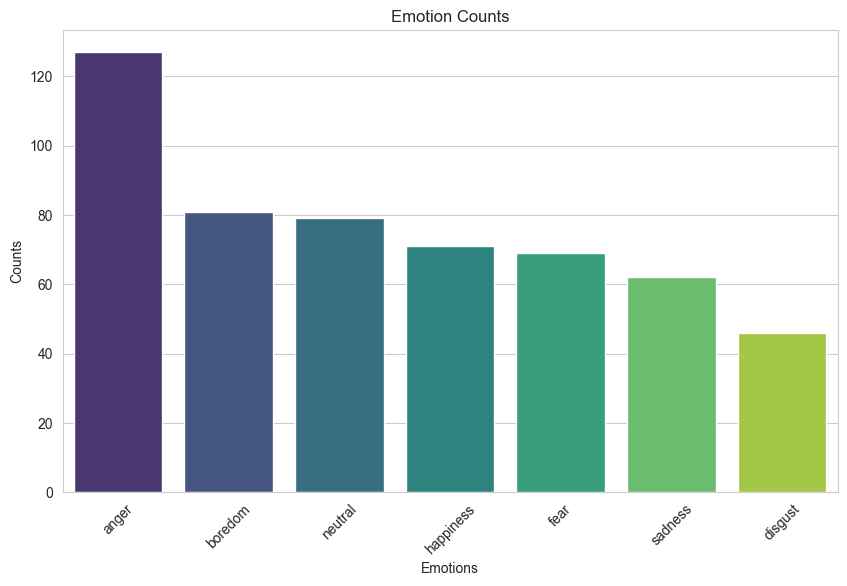

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

emotions = ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']
counts = [127, 81, 46, 69, 71, 79, 62]

sorted_data = sorted(zip(emotions, counts), key=lambda x: x[1], reverse=True)
sorted_emotions, sorted_counts = zip(*sorted_data)

sns.set_style("whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create the bar plot
sns.barplot(x=list(sorted_emotions), y=list(sorted_counts), palette='viridis')

# Set the labels and title
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.title('Emotion Counts')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Visualize Time Series

anger: 



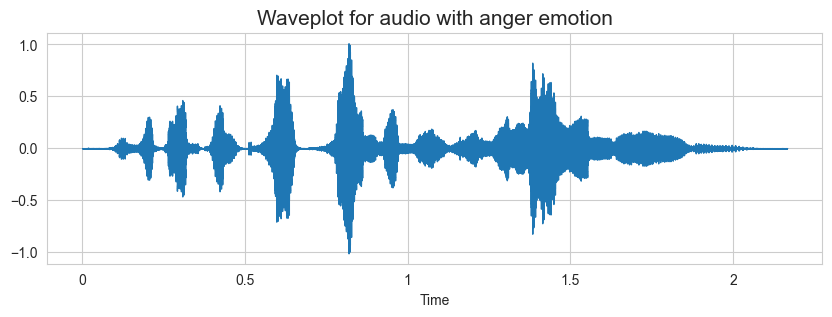

boredom: 



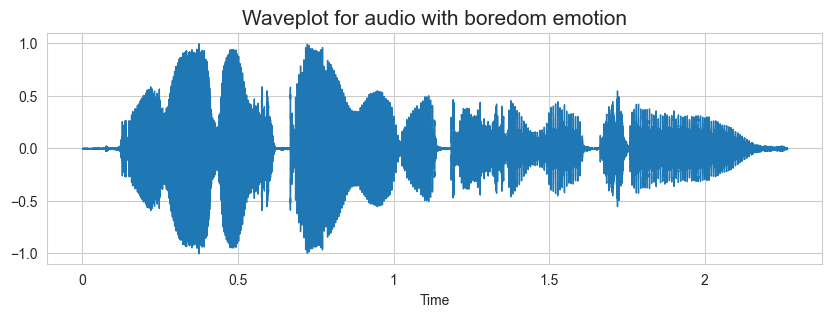

disgust: 



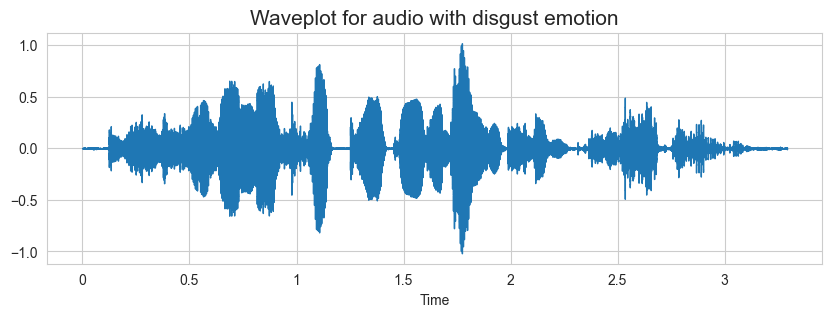

fear: 



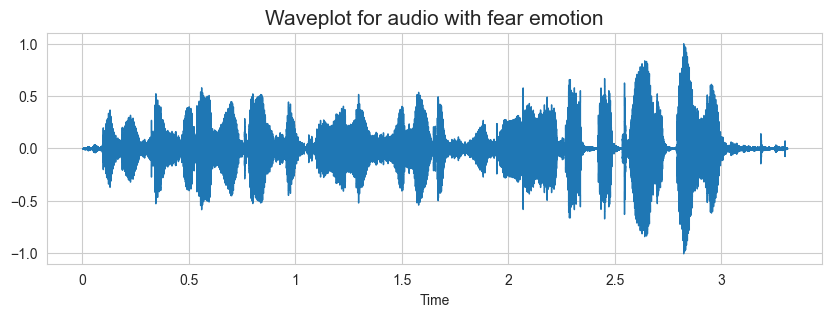

happiness: 



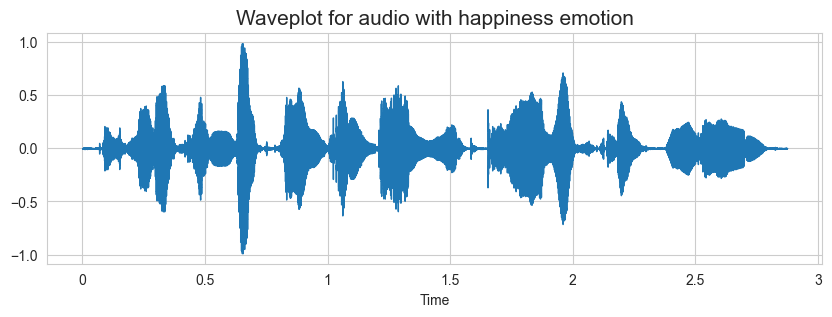

neutral: 



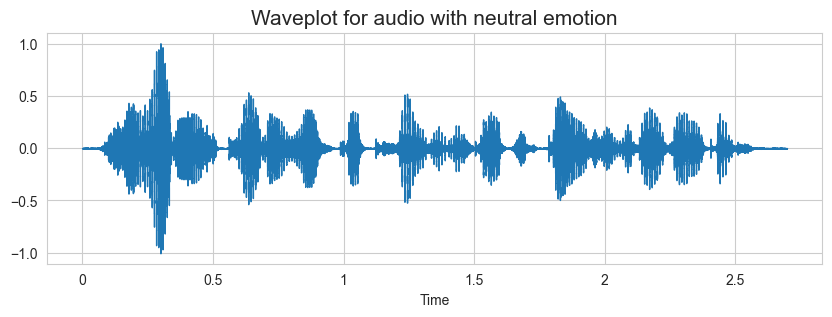

sadness: 



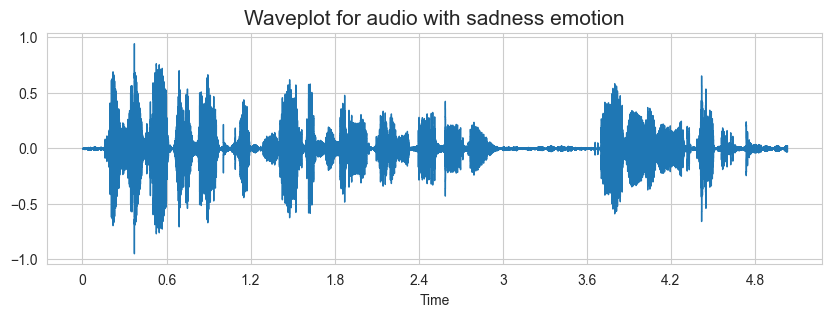

In [4]:
emotions = np.unique(data.loc[:,'emotion'].values)

for emotion in emotions:
    data_emotion = data.loc[data.loc[:,'emotion']==emotion]
    ts, sr = data_emotion.sample(n=1, random_state=13)[['ts', 'sr']].values[0]

    print(f'{emotion}: \n')
    plot_audio.create_waveplot(ts, sr,  emotion)
    

## c) Split Train Test

We split the dataset in 2 and end up with a trainset and a test. 

The trainset is use for training models, fine tune models and model selection. 

The test set is **ONLY** used to evaluate the performance of the final models. 

To avoid overfitting we separate the data by users, if a user is in the trainset then all the records of this user will be on the trainset and none on the test set

(0.0, 110.0)

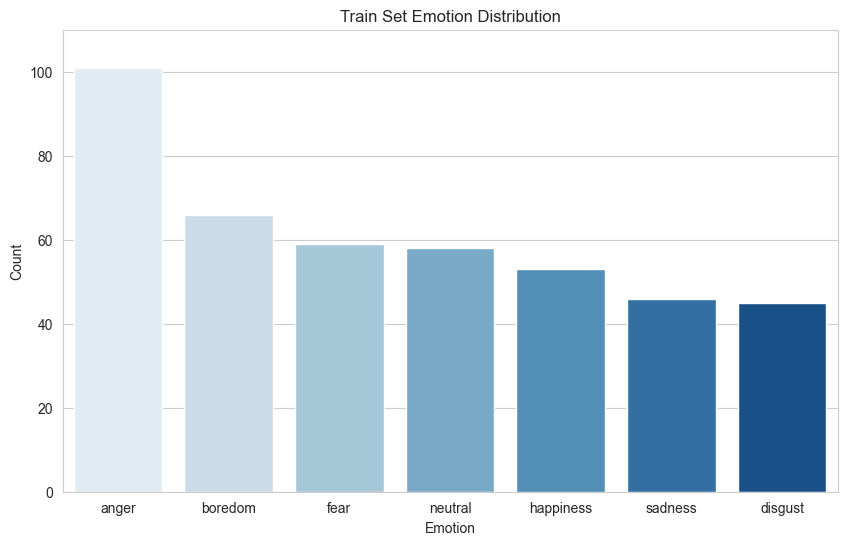

In [37]:
train, test = manageData.splitTrainTestByUser(data)



sns.set_style("whitegrid")  # Set the style of the plot
fig, axes = plt.subplots(1, 1, figsize=(10, 6))  # Set the size of the plot


emotions, counts = np.unique(train.loc[:,'emotion'], return_counts=True)
sorted_data = sorted(zip(emotions, counts), key=lambda x: x[1], reverse=True)
sorted_emotions, sorted_counts = zip(*sorted_data)
axes.set_title("Train Set Emotion Distribution")
# Create the bar plot
sns.barplot(x=list(sorted_emotions), y=list(sorted_counts), palette='Blues', ax=axes)


axes.set_xlabel("Emotion")
axes.set_ylabel("Count")
axes.set_ylim((0,110))
# Set the labels and title


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


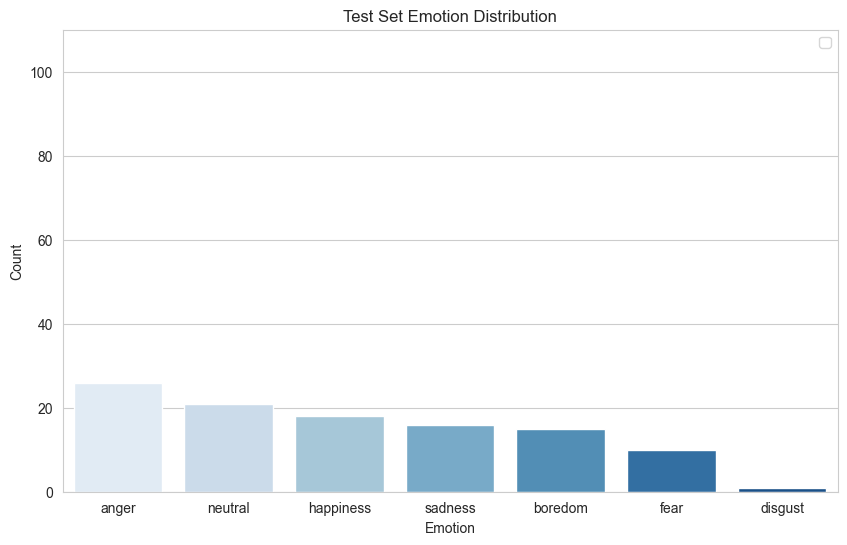

In [38]:
sns.set_style("whitegrid")  # Set the style of the plot
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

emotions, counts = np.unique(test.loc[:,'emotion'], return_counts=True)
sorted_data = sorted(zip(emotions, counts), key=lambda x: x[1], reverse=True)
sorted_emotions, sorted_counts = zip(*sorted_data)

axes.set_title("Test Set Emotion Distribution")

sns.barplot(x=list(sorted_emotions), y=list(sorted_counts), palette='Blues')


axes.set_xlabel("Emotion")
axes.set_ylabel("Count")
axes.set_ylim((0,110))

plt.legend()

# Show the plot
plt.show()

# Feature Engineering & Modeling

## a) Define features

- Zero Cross Rate
- Chroma Stft
- Mfcc
- RMS
- MEL 
- Tonnetz

# b) Feature Selection

In this part we will select the best features to use for our model.

In [6]:
code_emotions = {'W': 'anger', 'L':'boredom', 'E':'disgust', 'A':'fear',
                'F':'happiness', 'T':'sadness', 'N':'neutral'}
label2int = {'N':0, 'A':1, 'E':2, 'F':3, 'L':4, 'T':5, 'W':6}
emotion2int = {'neutral':0, 'fear':1, 'disgust':2, 'happiness':3, 'boredom':4, 'sadness':5, 'anger':6}

In [7]:
from src.extractFeatures import FeatureExtractor


features_group_1 = ['MeanZcr', 'MeanChromaStft', 'MeanMfcc','MeanRMS', 'MeanMEL','length' ,'Mean']
features_group_2 = ['MeanZcr', 'StdZcr', 'MeanChromaStft', 'StdChromaStft', 'MeanMfcc', 'StdMfcc','MeanRMS', 'StdRMS',
                        'MeanMEL', 'StdMEL','length' ,'Mean', 'Std']


extract_features = FeatureExtractor()

X_train = np.apply_along_axis(lambda x: extract_features(x[0], x[1]), axis=1, arr=np.array(train.loc[:,['ts', 'sr']].values))

y_train = train.loc[:,'label'].apply(lambda x: label2int[x]).values

X_test = np.apply_along_axis(lambda x: extract_features(x[0], x[1]), axis=1, arr=np.array(test.loc[:,['ts', 'sr']].values))
y_test = test.loc[:,'label'].apply(lambda x: label2int[x]).values

### Anova Feature Selection

A first step for feature selection is to perform an ANOVA test on the features. 

The null hypothesis for ANOVA assumes that the linear coefficients for your features are null. 

$$0=\beta_1 = \beta_2 = .... = \beta_k$$

We calculate the F-statistic as:

$$F=\frac{\frac{SSR}{k}}{\frac{SSE}{N-p-1}}$$

k is the number of parameters and N the number of data points.

The F-Statistic follows a Chi-Square distribution, therefore we calculate and we look if the value is likely to be sample by an F statistic, if it is the case then the null hypothesis is valid. If the F-statistic is very unlikely to be sampled then the hypothesis will be rejected.

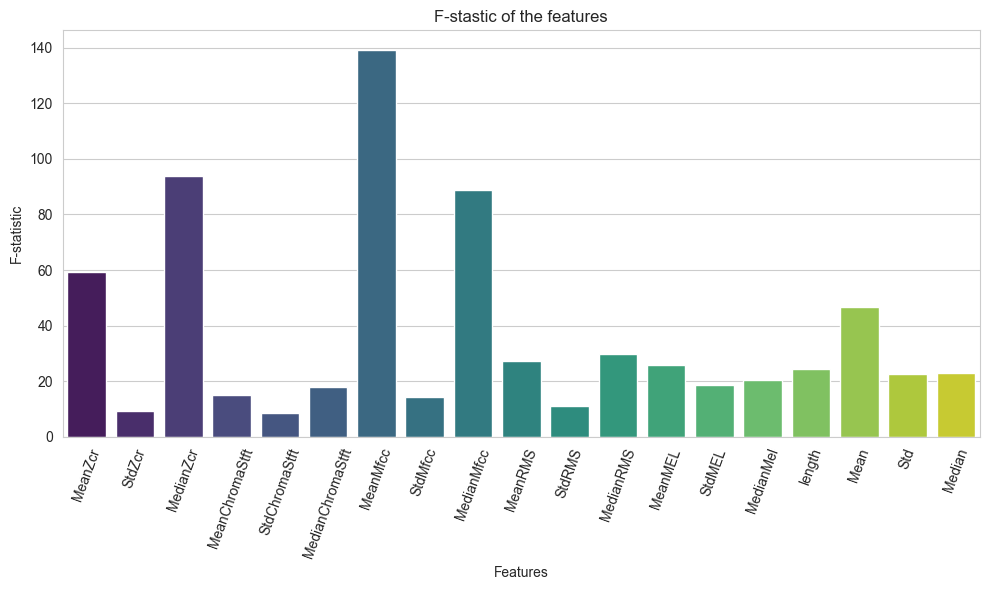

In [8]:
feature_names = list(extract_features.features.keys())

from sklearn.feature_selection import f_classif
f_value = f_classif(X_train, y_train)


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=f_value[0], palette="viridis")
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.title('F-stastic of the features')
plt.xticks(rotation=70)
plt.tight_layout()


In [44]:
print(f'the greatest p-value is: {max(f_value[1])}')

the greatest p-value is: 1.0654774815405565e-08


All of the F-statistics are very big. 

The greatest p-value is 1e-8 which means that the probability of the coefficient being null is almost 0. 

The Anova test tells us that all of our features are relevant

### Comparing Model performance over sets of features

Thanks to the tests we have seen that the ...
Let's look if there is a significant 

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

models = {}

models['LGR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', LogisticRegression(class_weight='balanced'))
])

models['RFC'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
])

In [10]:
for k, feature_group in enumerate([features_group_1, features_group_2, None]):
    X_train = np.apply_along_axis(lambda x: extract_features(x[0], x[1], feature_group), axis=1, arr=np.array(train.loc[:,['ts', 'sr']].values))
    print(f'For features group {k+1}:')
    
    for name, model in models.items():
        evaluation.CrossValidationByUser(X_train, y_train, model, train.loc[:,'user_id'].values, name)

For features group 1:
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.44+-0.13|0.51+-0.13|0.48+-0.13|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC|0.45+-0.17|0.49+-0.16|0.47+-0.17|
For features group 2:
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.49+-0.16|0.57+-0.14|0.51+-0.15|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC|0.45+-0.18|0.50+-0.17|0.47+-0.16|
For features group 3:
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.49+-0.14|0.57+-0.14|0.52+-0.14|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC|0.47+-0.16|0.54+-0.16|0.50+-0.15|


For features group 1:

|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.44+-0.13|0.51+-0.13|0.48+-0.13|
|RFC|0.44+-0.15|0.49+-0.14|0.47+-0.15|

For features group 2:
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.49+-0.16|0.57+-0.14|0.51+-0.15|
|RFC|0.44+-0.17|0.47+-0.15|0.47+-0.16|

For features group 3:

|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.49+-0.14|0.57+-0.14|0.52+-0.14|
|RFC|0.46+-0.15|0.52+-0.14|0.49+-0.14|

## b) Classical ML 

Let's

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


models = {}

models['LGR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', LogisticRegression(class_weight='balanced'))
])

models['RFC_50'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=50, oob_score=True, class_weight='balanced'))
])

models['RFC_100'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=100, oob_score=True, class_weight='balanced'))
])

models['RFC_200'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=200, oob_score=True, class_weight='balanced'))
])

models['XGB_50'] =  Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('cls', xgb.XGBClassifier(n_estimators=50))
])

models['XGB_100'] =  Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('cls', xgb.XGBClassifier(n_estimators=100))
])

models['XGB_200'] =  Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('cls', xgb.XGBClassifier(n_estimators=200))
])

for name, model in models.items():
    evaluation.CrossValidationByUser(X_train, y_train, model, train.loc[:,'user_id'].values, name)

|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.49+-0.14|0.57+-0.14|0.52+-0.14|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC_50|0.46+-0.17|0.52+-0.14|0.49+-0.16|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC_100|0.47+-0.16|0.53+-0.15|0.49+-0.16|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC_200|0.47+-0.17|0.54+-0.16|0.50+-0.16|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|XGB_50|0.46+-0.15|0.50+-0.17|0.49+-0.14|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|XGB_100|0.46+-0.14|0.50+-0.17|0.48+-0.13|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|XGB_200|0.46+-0.14|0.49+-0.17|0.48+-0.13|


|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.49+-0.14|0.57+-0.14|0.52+-0.14|
|RFC_50|0.45+-0.14|0.53+-0.15|0.48+-0.14|
|RFC_100|0.47+-0.16|0.56+-0.16|0.50+-0.15|
|RFC_200|0.47+-0.16|0.56+-0.17|0.49+-0.15|
|XGB_50|0.46+-0.15|0.50+-0.17|0.49+-0.14|
|XGB_100|0.46+-0.14|0.50+-0.17|0.48+-0.13|
|XGB_200|0.46+-0.14|0.49+-0.17|0.48+-0.13|


## c) Deep Learning Models

Now let's try for neural network models

#### Cross Validation

In [24]:
from src import models

nets = {'stardardNet50': models.StandardNet(X_train.shape[1], 50),
        'standardNet100': models.StandardNet(X_train.shape[1], 100),
        'standardNet200': models.StandardNet(X_train.shape[1], 200),
        'netBn50': models.StandardNetBn(X_train.shape[1], 50),
        'netBn100': models.StandardNetBn(X_train.shape[1], 100),
        'netBn200': models.StandardNetBn(X_train.shape[1], 200),
        'netBnDr50': models.StandardNetBnD(X_train.shape[1], 50),
        'netBnDr100': models.StandardNetBnD(X_train.shape[1], 100),
        'netBnDr200': models.StandardNetBnD(X_train.shape[1], 200),

        }

#for name, net in zip(['Standard Net 100', 'Net Batch Norm 100', 'Net Batch Norm'])
for name, net in nets.items():  
        print(name)
        nets[name] = models.CrossValidationByUserDl(X_train, y_train, net, train.loc[:,'user_id'].values, model_name=name, num_epochs=2000)

stardardNet50
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|stardardNet50|0.26+-0.07|0.27+-0.11|0.35+-0.07|
standardNet100
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|standardNet100|0.28+-0.07|0.29+-0.09|0.34+-0.05|
standardNet200
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|standardNet200|0.26+-0.10|0.28+-0.10|0.34+-0.07|
netBn50
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBn50|0.58+-0.08|0.62+-0.08|0.58+-0.09|
netBn100
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBn100|0.54+-0.06|0.58+-0.08|0.57+-0.07|
netBn200
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBn200|0.56+-0.07|0.60+-0.07|0.57+-0.07|
netBnDr50
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBnDr50|0.49+-0.08|0.51+-0.09|0.52+-0.08|
netBnDr100
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBnDr100|0.49+-0.06|0.54+-0.08|0.50+-0.06|
netBnDr200
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBnDr200|0.50+-0.06|

|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|stardardNet50|0.26+-0.07|0.27+-0.11|0.35+-0.07|
|standardNet100|0.28+-0.07|0.29+-0.09|0.34+-0.05|
|standardNet200|0.26+-0.10|0.28+-0.10|0.34+-0.07|
||
|netBn50|0.58+-0.08|0.62+-0.08|0.58+-0.09|
|netBn100|0.54+-0.06|0.58+-0.08|0.57+-0.07|
|netBn200|0.56+-0.07|0.60+-0.07|0.57+-0.07|
||
|netBnDr50|0.49+-0.08|0.51+-0.09|0.52+-0.08|
|netBnDr100|0.49+-0.06|0.54+-0.08|0.50+-0.06|
|netBnDr200|0.50+-0.06|0.53+-0.07|0.52+-0.06|

### Train best

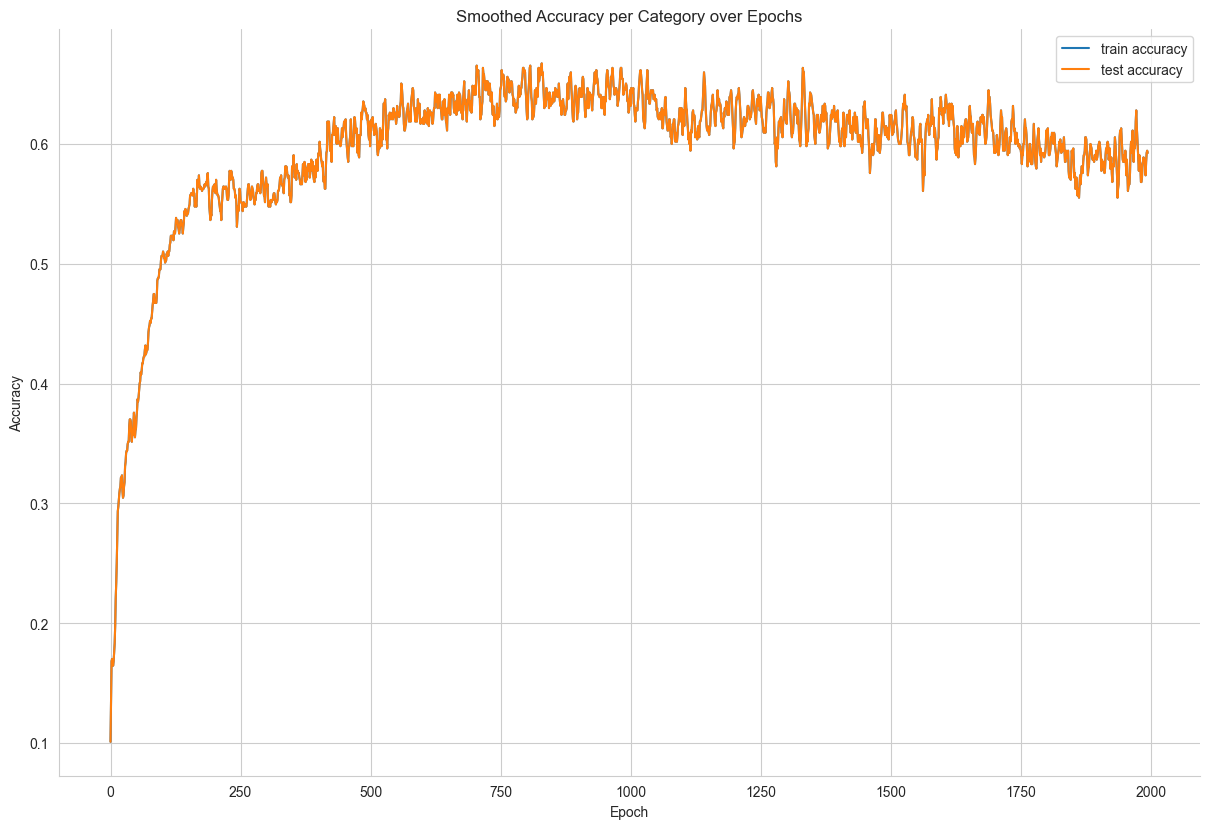

<module 'matplotlib.pyplot' from '/Users/alejandrobonell/.pyenv/versions/miniforge3-4.10.3-10/envs/speech_recognition/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [12]:
from src import models

net = models.StandardNetBn(X_train.shape[1], 50)
net, acc_train, acc_test = models.train_net_with_val_results(net, X_train, y_train, X_test, y_test, num_epochs=2000, batch_size=50, learning_rate=1e-4)
plot_audio.plot_nets(acc_train, acc_test)

# Results & Visualizations

## a) Best results for Classical ML model

For classical ML models the best architectures were:

- Logistic Regression
    - class_weight = balanced
- Random Forest
    - num_estimators=100
- xgboost
    - num_estimators=50


In [17]:
models = {}

models['LGR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', LogisticRegression(class_weight='balanced'))
])


models['RFC_100'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=100, oob_score=True, class_weight='balanced'))
])


models['XGB_50'] =  Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('cls', xgb.XGBClassifier(n_estimators=50))
])

for name, model in models.items():
    model.fit(X_train, y_train)

LGR:


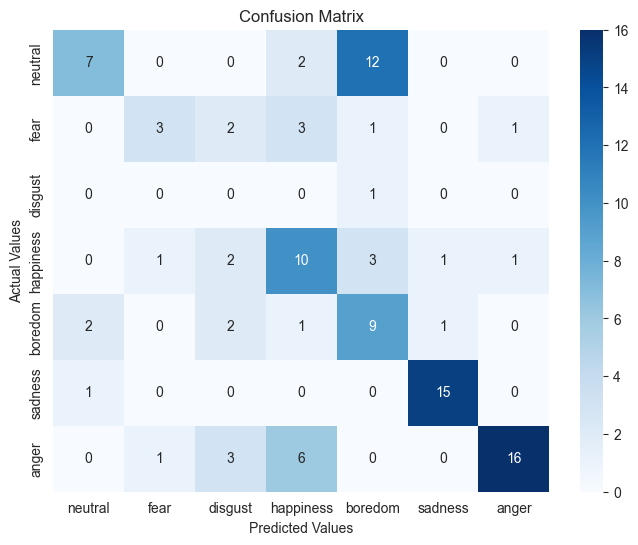

Results model with username where accuracy is:  0.5607476635514018
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.70|0.33|0.45|
|fear|0.60|0.30|0.40|
|disgust|0.00|0.00|nan|
|happiness|0.45|0.56|0.50|
|boredom|0.35|0.60|0.44|
|sadness|0.88|0.94|0.91|
|anger|0.89|0.62|0.73|
----
RFC_100:


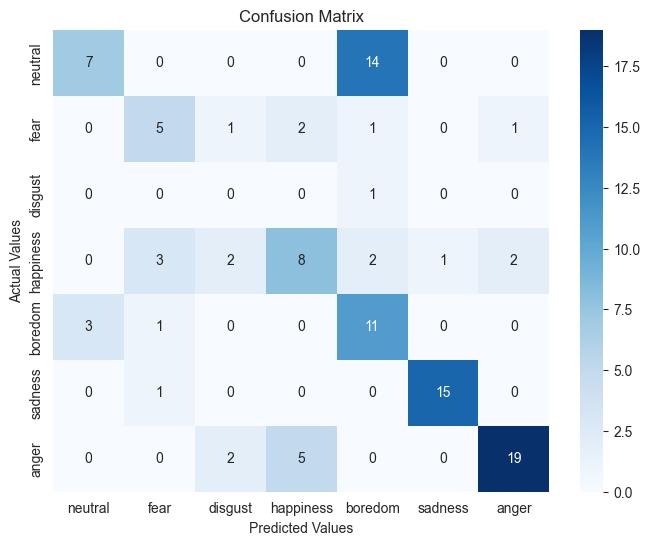

Results model with username where accuracy is:  0.6074766355140186
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.70|0.33|0.45|
|fear|0.50|0.50|0.50|
|disgust|0.00|0.00|nan|
|happiness|0.53|0.44|0.48|
|boredom|0.38|0.73|0.50|
|sadness|0.94|0.94|0.94|
|anger|0.86|0.73|0.79|
----
XGB_50:


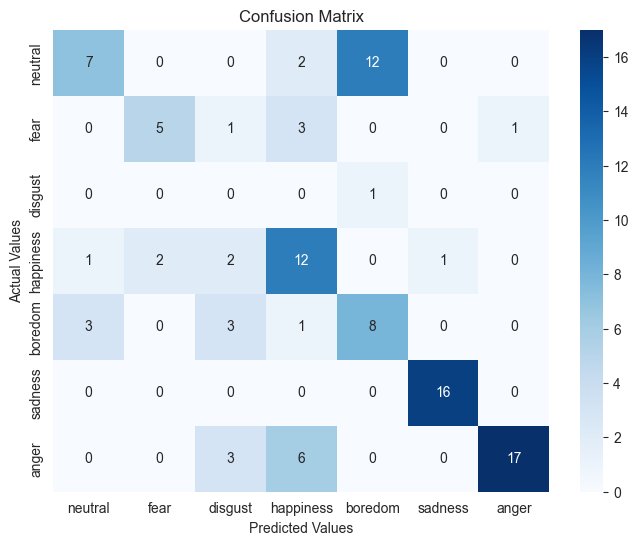

Results model with username where accuracy is:  0.6074766355140186
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.64|0.33|0.44|
|fear|0.71|0.50|0.59|
|disgust|0.00|0.00|nan|
|happiness|0.50|0.67|0.57|
|boredom|0.38|0.53|0.44|
|sadness|0.94|1.00|0.97|
|anger|0.94|0.65|0.77|
----


In [18]:
for name, model in models.items():
    print(f'{name}:')
    evaluation.metrics_report(y_test, model.predict(X_test), emotion2int)
    print('----')

## b) Best results for DL models

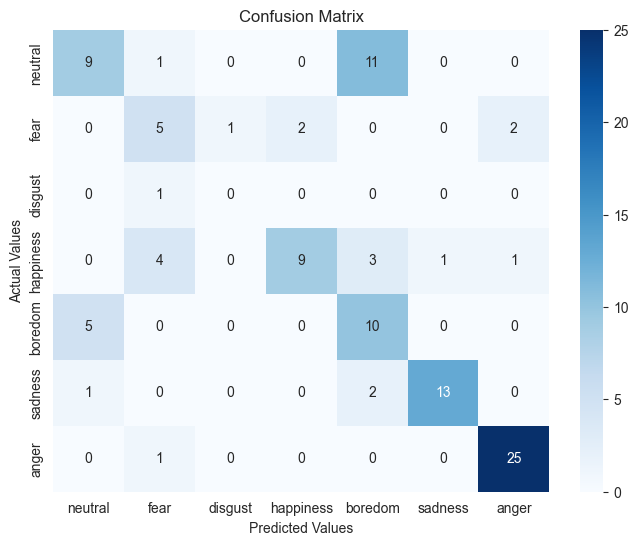

Results model with username where accuracy is:  0.6635514018691588
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.60|0.43|0.50|
|fear|0.42|0.50|0.45|
|disgust|0.00|0.00|nan|
|happiness|0.82|0.50|0.62|
|boredom|0.38|0.67|0.49|
|sadness|0.93|0.81|0.87|
|anger|0.89|0.96|0.93|


In [24]:
outputs = net(torch.Tensor(X_test))
preds = torch.argmax(outputs, dim=1).detach().numpy()

evaluation.metrics_report(y_test, preds, emotion2int)


Results model with username where accuracy is:  0.6635514018691588
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.60|0.43|0.50|
|fear|0.42|0.50|0.45|
|disgust|0.00|0.00|nan|
|happiness|0.82|0.50|0.62|
|boredom|0.38|0.67|0.49|
|sadness|0.93|0.81|0.87|
|anger|0.89|0.96|0.93|